In [1]:
# !pip install umap-learn ipdb
# !pip install jupyter-dash
# !pip install ipympl
# !jupyter nbextension enable --py --sys-prefix ipympl
## RUN THIS AS A NOTEBOOK! help-->Launch Classic Notebook

# unused strategy: https://dash.plotly.com/dash-core-components/tooltip

In [2]:
 import os
 os.system('hostname')

dshift-parser


0

In [2]:
%matplotlib inline
# %matplotlib widget
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import os
from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from os.path import join
from cifarclass import cifar100_classes
from scipy.interpolate import interp1d

import seaborn as sns
import colorcet as cc
from ipdb import set_trace
import pandas as pd
from p_tqdm import p_map # parallel map
pmap = p_map

import PIL
from io import BytesIO
import PIL.Image
from tqdm.auto import tqdm

import umap
from sklearn.manifold import TSNE

label_mapping=cifar100_classes
classes = list(label_mapping.values())

rand_indices = np.random.default_rng(2).choice(np.arange(10000), size=10)

def probs_to_softacc(probs):
    return np.array([probs[i, yi, :] for i, yi in enumerate(ytest)]).mean(0)

In [3]:
name = "CIFAR100_test"
train_set = "CIFAR100_train"

print("loading data")
grouped = load_pickle('../processed/cifar100/resnets/group2.pkl')
groups = list(grouped[name].keys())
group = groups[0]
print(groups)
print("done")

print("loading dataset")
dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print("done")

loading data
['Resnet18-pretrained', 'Densenet121-pretrained', 'Resnet18', 'Densenet121']
done
loading dataset
Files already downloaded and verified
done


In [14]:
G = grouped[name][group]

def get_embed2d(index, G=grouped[name][group], t="probs", gridpts=50, height=50, topk=5):
    true_label = ytest[index]
    W, H = gridpts, height
    hh = np.linspace(0, 1, H).reshape(1, H)
    
    if t=="probs":
        x = probs_to_softacc(G["probs"])
    else:
        x = G["x"]
        
    areas = G[t][index].sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals
    top_labels = ind

    embed = np.zeros((W, H))
    curr = np.zeros(W) # the current line
    color = 1.0 # current color [0, 1]
    xx = np.linspace(x.min(), x.max(), gridpts)
    for i, lab in enumerate(top_labels):
        # linearly interpolate the curve on uniform grid
        y = G[t][index][lab]
        f = interp1d(x, y, kind='linear')
        yy = f(xx)
        
        curr += yy
        #color = 1.0 - i/(len(top_labels)-1)
        prescale = (len(top_labels)/topk) # = 1 for including all the labels
        color = 1.0 -  prescale * i/(len(top_labels)-1)
        color = np.clip(color, 0, 1)
        
        mask = color*(hh <= curr.reshape(W, 1))
        embed = np.maximum(embed, mask)
        
    return embed

def get_icon(index, width=16, topk=2, cmap='rainbow'):
    e = get_embed2d(index, gridpts=width,height=width, t="probs", topk=topk)
    e = e.T[::-1,:]
    cm = plt.get_cmap(cmap)
    img = PIL.Image.fromarray(np.uint8(cm(1-e)*255)) # grayscale --> color
    return img


In [5]:
all_areas = np.array([np.mean(G["probs"][i, yi, :]) for i, yi in enumerate(ytest)])
all_final_accs = np.array([G["probs"][i, yi, -1] for i, yi in enumerate(ytest)])

N = 2000
INDICES = np.flatnonzero(all_final_accs < 1.5)[:N] # select only "hard" pts
final_accs = all_final_accs[INDICES]
areas = all_areas[INDICES]

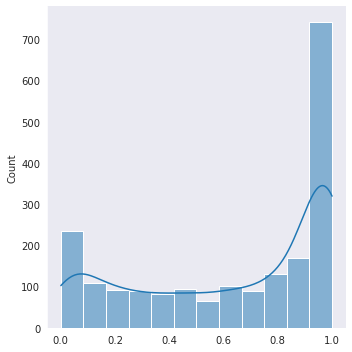

In [13]:
sns.set_style("dark")
sns.displot(final_accs, kde=True,label="final acc")